In [7]:
%load_ext autoreload
%autoreload 2

import json
import pandas as pd
from pandas import DataFrame
from bs4 import BeautifulSoup

from src.forum_gql_utils import *

from tqdm.auto import tqdm
tqdm.pandas()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


See https://forum.effectivealtruism.org/graphiql for interactive version and https://www.lesswrong.com/posts/LJiGhpq8w4Badr5KJ/graphql-tutorial-for-lesswrong-and-effective-altruism-forum for a manual.

## Scrape

### Posts

In [6]:
posts = scrape_forum(content='posts', url=EA_GQL_URL, limit=15000, step=1000)
len(posts)

100%|██████████| 15/15 [01:16<00:00,  5.08s/it]


10898

In [8]:
post_df = DataFrame(posts).set_index('_id')
post_df['tags'] = post_df.tags.map(lambda x: [v['name'] for v in x])
post_df['postedAt'] = pd.to_datetime(post_df['postedAt'])

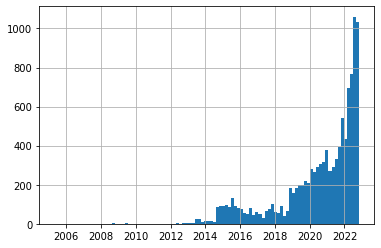

In [10]:
post_df[post_df.postedAt > post_df.postedAt.min()].postedAt.hist(bins=100); # remove 1970

In [11]:
post_df['body'] = post_df.htmlBody.progress_map(lambda h: BeautifulSoup(h, features="html.parser").get_text())

100%|██████████| 10898/10898 [01:18<00:00, 139.21it/s]


In [13]:
post_df.to_csv('./data/posts.csv')

### Users

In [20]:
users = scrape_forum(content='users', url=EA_GQL_URL, limit=30000)
len(users)

100%|██████████| 6/6 [00:52<00:00,  8.68s/it]


24512

In [21]:
user_df = DataFrame(users).set_index('_id')
user_df.to_csv('./data/users.csv')

### Comments

In [28]:
comments = scrape_forum(content='comments', url=EA_GQL_URL, limit=200000)
len(comments)

100%|██████████| 40/40 [04:56<00:00,  7.40s/it]


103559

In [50]:
comments_df = DataFrame(comments).set_index('_id')
comments_df = comments_df[(~comments_df.user.isna()) & (~comments_df.htmlBody.isna())]

comments_df['username'] = comments_df.user.map(lambda x: x['username'])
comments_df['userId'] = comments_df.user.map(lambda x: x['_id'])
del comments_df['user']

comments_df['allVotes'] = comments_df['allVotes'].map(lambda x: ','.join([v['voteType'] for v in x]))

In [51]:
comments_df['body'] = comments_df.htmlBody.progress_map(lambda h: BeautifulSoup(h, features="html.parser").get_text())

 85%|████████▍ | 87230/103119 [00:39<00:06, 2395.59it/s]/home/vpetukhov/local/miniconda3/envs/scrapping/lib/python3.8/site-packages/bs4/__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
100%|██████████| 103119/103119 [00:45<00:00, 2272.91it/s]


In [52]:
comments_df.to_csv('./data/comments.csv')